In [2]:
import simplified_env as env
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Parameters

In [3]:
epsilon = 0.00001
#starting_grid = np.array([0,1,0,0,0,0,0])
#starting_grid = np.array([1/7,1/7,1/7,1/7,1/7,1/7,1/7])
starting_grid = np.array([1,0,0,0,0,0,0])


## Environment

In [4]:
environment = env.env(starting_grid=starting_grid)

Environment Ready.


In [5]:
display(environment.probability_matrix)

array([[0.6, 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.2, 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0.4, 0.2, 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.4, 0.2, 0.4, 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0.2, 0.4, 0. ],
       [0. , 0. , 0. , 0. , 0.4, 0.2, 0.4],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0.6]])

## Experiment

In [6]:
old_result = environment.starting_grid
result = np.matmul(environment.starting_grid, environment.probability_matrix)
vmin = np.min(old_result)
vmax = np.max(old_result)


#heatmap_series = [plot_heatmap(old_result),plot_heatmap(result)]
results_series = [old_result,result]


while np.max(np.abs(result - old_result)) > epsilon:
    old_result = result
    result = np.matmul(result, environment.probability_matrix)

    #heatmap_series.append( plot_heatmap(result) )
    results_series.append(result)

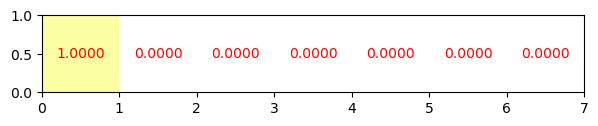

In [7]:
fig, ax = plt.subplots(figsize=(7,1))

log_norm = LogNorm(vmin=vmin, vmax=vmax)


def update(frame):
    cmap = plt.get_cmap('inferno')
    ax.clear()
    result = results_series[frame]
    normed_values = (result - np.min(result)) / (np.max(result) - np.min(result))

    for i, value in enumerate(result):
        plt.text(i + 0.5, 0.5, f'{value:.4f}', color='red', ha='center', va='center')

    ax.imshow(normed_values.reshape(1, -1), cmap=cmap, aspect='auto', extent=[0, len(result), 0, 1], norm=log_norm)

ani = FuncAnimation(fig, update, frames=len(results_series), interval=500, repeat=False)

HTML(ani.to_jshtml())

In [8]:
print(result)

[0.1429731  0.14295014 0.14290875 0.14285714 0.14280554 0.14276415
 0.14274118]


### Episode Sampling

In [9]:
episode = environment.sample_episode(10)    
print( episode )

[0, 1, 0, 1, 2, 1, 2, 3, 4, 5]


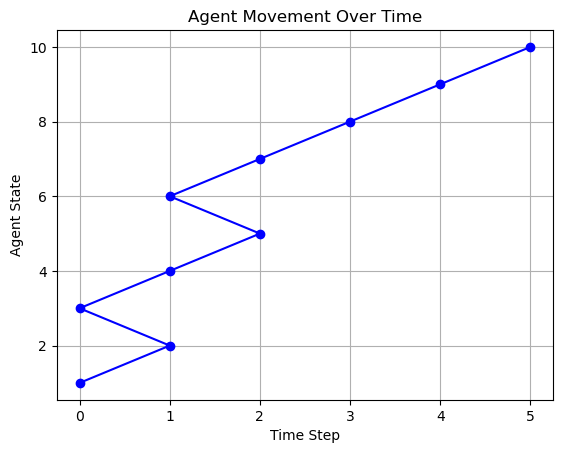

In [10]:
time_steps = range(1, len(episode) + 1)
plt.plot(episode, time_steps, marker='o', linestyle='-', color='b')

plt.xlabel('Time Step')
plt.ylabel('Agent State')
plt.title('Agent Movement Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# Rewards

In [11]:
utils.return_function(episode, environment.rewards, environment.DISCOUNT_FACTOR)

1.25

### Computing the value function

Estimated by simulation

In [12]:
returns = {}
for s in tqdm(environment.states):
    returns[s] = []
    environment.starting_state = s
    for i in range(10000):
        episode = environment.sample_episode(100)
        returns[s].append( utils.return_function(episode, environment.rewards, environment.DISCOUNT_FACTOR) )


 29%|██▊       | 2/7 [00:28<01:10, 14.07s/it]

In [ ]:
mean_returns = [np.mean(returns[s]) for s in environment.states]   
mean_returns

[1.53642427377885,
 0.36410819874245043,
 0.1318189070699208,
 0.20939771576182567,
 0.8474711166123787,
 3.5533363258042896,
 15.391212496435095]

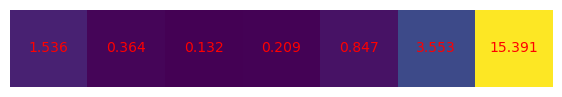

In [ ]:
utils.plot_heatmap(mean_returns)

Bellman Equation

$V = (I - \gamma P)^{-1} R$

In [ ]:
r = environment.rewards
r

[1, 0, 0, 0, 0, 0, 10]

In [ ]:
p = environment.probability_matrix
identity = np.identity(p.shape[0])

In [ ]:
v = (np.linalg.inv(identity - environment.DISCOUNT_FACTOR * p) @ r)

In [ ]:
v

array([ 1.53426666,  0.3699333 ,  0.13043318,  0.21701603,  0.84613895,
        3.59060924, 15.31160264])

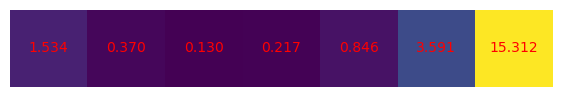

In [ ]:
utils.plot_heatmap(v)

Power Iteration

$V_k(s) = (R + \gamma P) V_{k-1}$

In [ ]:
v_pi = {}
v_pi[0] = [0] * len(r)
r = environment.rewards
p = environment.probability_matrix
gamma = environment.DISCOUNT_FACTOR

v_pi[0]

[0, 0, 0, 0, 0, 0, 0]

In [ ]:
p

NameError: name 'p' is not defined

In [20]:
v_pi[1] = (r + gamma * p @ v_pi[0])
v_pi[1]

i = 1
while np.max(np.abs(v_pi[i] - v_pi[i-1])) > epsilon:
    v_pi[i+1] = (r + gamma * p @ v_pi[i])
    i += 1

In [21]:
v_pi[i]

array([ 1.53426245,  0.36992875,  0.130428  ,  0.21701004,  0.84613216,
        3.5906018 , 15.31159484])

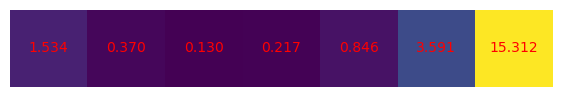

In [22]:
utils.plot_heatmap(v_pi[i])